# Segmentação de Imagens de Trânsito

O objetivo deste exercicio é desenvolver um modelo de segmentação de imagens.

O dataset utilizado é o [CamSeq01](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/), que possui apenas 101 imagens de alta resolução. Cada pixel é rotulado como uma de 32 classes (carro, pedestre, etc).

Existem apenas 71 imagens de treino e 30 de teste.

A métrica oficial é a DICE.

Dica de como calculá-la: https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i

### Download do Dataset

In [ ]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/CamSeq01.zip .
!unzip CamSeq01.zip

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/CamSeq01.zip...
- [1/1 files][ 90.3 MiB/ 90.3 MiB] 100% Done                                    
Operation completed over 1 objects/90.3 MiB.                                     
Archive:  CamSeq01.zip
   creating: CamSeq01/
  inflating: CamSeq01/.DS_Store      
  inflating: __MACOSX/CamSeq01/._.DS_Store  
   creating: CamSeq01/test/
  inflating: CamSeq01/label_colors.txt  
   creating: CamSeq01/train/
  inflating: CamSeq01/readme.txt     
  inflating: CamSeq01/test/0016E5_08137.png  
  inflating: CamSeq01/test/0016E5_08123.png  
  inflating: CamSeq01/test/0016E5_08139_L.png  
  inflating: CamSeq01/test/0016E5_08095.png  
  inflating: CamSeq01/test/0016E5_08141_L.png  
  inflating: CamSeq01/test/0016E5_08143_L.png  
  inflating: CamSeq01/test/0016E5_08097.png  
  inflating: CamSeq01/test/0016E5_08135.png  
  inflating: CamSeq01/test/0016E5_08121.png  
  inflating: CamSeq01/test/0016E5_08109.png  
  inflating: CamSeq01/test/0

## Inicialização

In [ ]:
import PIL
from torchvision import transforms
import os
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
! pip install neptune-client==0.9.1

     |████████████████████████████████| 215kB 24.8MB/s 
     |████████████████████████████████| 829kB 45.7MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 174kB 36.1MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 133kB 56.9MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=9c215807d71db1c2e036b2eeddafea40a20b24d4a71f9598dec0e127e3ea3660
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=a6666666b50ccdb385661e1987460b66fb81f7d568e893ca6e1ab1cfa619ee6b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

In [ ]:
import neptune.new as neptune

run = neptune.init(project='eduardocoraca/aula8', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmMzZmYmY3MC01NWJjLTQ1MjItYmVjMC0zNGNjNGZiMDA4YzcifQ==')

https://app.neptune.ai/eduardocoraca/aula8/e/AUL1-8


In [ ]:
!pip install pytorch_lightning
import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer

pytorch_lightning.utilities.seed.seed_everything(seed=123)

Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated


Global seed set to 123


123

## Criando o Dataset

In [ ]:
# caminhos para os arquivos

files_train = os.listdir('/content/CamSeq01/train')
files_train = [ '/content/CamSeq01/train/' + x.split('.png')[0] for x in files_train if "_L" not in x ]

files_test = os.listdir('/content/CamSeq01/test')
files_test = [ '/content/CamSeq01/test/' + x.split('.png')[0] for x in files_test if "_L" not in x ]

In [ ]:
train_subset, val_subset = torch.utils.data.random_split(files_train, [50,16])

In [ ]:
# criando dicionários para as labels

data = []
pixel = []
label = []

with open('/content/CamSeq01/label_colors.txt') as file:
    lines = file.readlines()
    for line in lines:
        data = line.split('\t')
        pixel.append(data[0])
        label.append(data[-1].split('\n')[0])

rgb2label = dict(zip(pixel,label))
label2y = dict(zip(np.unique(label), np.arange(len(np.unique(label)))))

rgb2label

{'0 0 0': 'Void',
 '0 0 192': 'Sidewalk',
 '0 0 64': 'TrafficCone',
 '0 128 192': 'Bicyclist',
 '0 128 64': 'Bridge',
 '0 64 64': 'TrafficLight',
 '128 0 0': 'Building',
 '128 0 192': 'LaneMkgsDriv',
 '128 128 0': 'Tree',
 '128 128 128': 'Sky',
 '128 128 192': 'RoadShoulder',
 '128 128 64': 'Misc_Text',
 '128 64 128': 'Road',
 '128 64 64': 'OtherMoving',
 '192 0 128': 'Archway',
 '192 0 192': 'MotorcycleScooter',
 '192 0 64': 'LaneMkgsNonDriv',
 '192 128 128': 'SignSymbol',
 '192 128 192': 'Truck_Bus',
 '192 128 64': 'Child',
 '192 192 0': 'VegetationMisc',
 '192 192 128': 'Column_Pole',
 '192 64 128': 'Train',
 '64 0 128': 'Car',
 '64 0 192': 'CartLuggagePram',
 '64 0 64': 'Tunnel',
 '64 128 192': 'SUVPickupTruck',
 '64 128 64': 'Animal',
 '64 192 0': 'Wall',
 '64 192 128': 'ParkingBlock',
 '64 64 0': 'Pedestrian',
 '64 64 128': 'Fence'}

In [ ]:
# dicionários reversos
label2rgb = {v: k for k, v in rgb2label.items()}
y2label = {v: k for k, v in label2y.items()}

In [ ]:
num_classes = len(rgb2label)
print(f'Quantidade de classes: {num_classes}')

Quantidade de classes: 32


In [ ]:
# função para converter uma imagem PIL (L,H,3) para labels (L,H)

def pil2label(img_L):
    img = np.array(img_L)
    L = img.shape[0]
    H = img.shape[1]
    
    img_flat = img.reshape(-1,3)

    rgb = list(map(lambda x1,x2,x3: str(x1) + ' ' + str(x2) + ' ' + str(x3), list(img_flat[:,0]), list(img_flat[:,1]), list(img_flat[:,2])))
    y = list(map(lambda x: label2y[rgb2label[x]], rgb))
    return torch.Tensor(y).reshape(1,L,H)

In [ ]:
'''
# função para converter uma imagem de labels (L,H) para PIL (L,H,3)

def label2pil(labels):
    L = 256
    H = 256
    img = np.zeros((L,H,3))

    rgb_list = list(map(lambda x: label2rgb[y2label[int(x)]], list(y[0].view(-1))))
    rgb_array = np.array(rgb_list).reshape(L,H)

    for i in range(L):
      for j in range(H):
        rgb = rgb_array[i,j].split(' ')
        img[i,j,0] = int(rgb[0])
        img[i,j,1] = int(rgb[1])
        img[i,j,2] = int(rgb[2])
    
    return img
'''

"\n# função para converter uma imagem de labels (L,H) para PIL (L,H,3)\n\ndef label2pil(labels):\n    L = 256\n    H = 256\n    img = np.zeros((L,H,3))\n\n    rgb_list = list(map(lambda x: label2rgb[y2label[int(x)]], list(y[0].view(-1))))\n    rgb_array = np.array(rgb_list).reshape(L,H)\n\n    for i in range(L):\n      for j in range(H):\n        rgb = rgb_array[i,j].split(' ')\n        img[i,j,0] = int(rgb[0])\n        img[i,j,1] = int(rgb[1])\n        img[i,j,2] = int(rgb[2])\n    \n    return img\n"

### Classe Dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, files, transform, transform_label):    
        img = []
        img_y = []
        for file in files:
            img.append(PIL.Image.open(file + '.png'))
            img_y.append(pil2label(PIL.Image.open(file + '_L.png')))

        self.images = img
        self.labels = img_y
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.transform_label(self.labels[idx]) # converte as labels para tensor
        img = self.transform(self.images[idx])

        return img, label

In [ ]:
# a classe DatasetTreino só deve ser utilizada para os dados de treinamento, 
# pois ela aplica a mesma transformação (crop) a duas imagens

class DatasetTreino(torch.utils.data.Dataset):

    def __init__(self, files, transform, size_final):    
        img = []
        img_y = []
        for file in files:
            img.append(PIL.Image.open(file + '.png'))
            img_y.append(pil2label(PIL.Image.open(file + '_L.png')))

        self.images = img
        self.labels = img_y
        self.transform = transform
        self.size_final = size_final

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = transforms.ToTensor()(self.images[idx])
        label = self.labels[idx]

        img_y_stack = torch.vstack((img,label))
        img_y_stack = transforms.RandomResizedCrop(size=self.size_final, scale=(0.2, 1.0))(img_y_stack)

        img_crop = img_y_stack[0:3]
        label_crop = img_y_stack[3]

        img_crop = self.transform(img_crop)

        return img_crop, label_crop

### Criando o Dataset e o Dataloader

Criando um dataset para determinar a média e desvio padrão do conjunto de treinamento

In [ ]:
size_final = (256,256)

transform_img_label = transforms.Compose([
                                      transforms.Resize(size_final),
                                    ])

transform_1 = transforms.Compose([
                                  transforms.Resize(size_final),
                                  transforms.ToTensor(),
                                  ])

train_dataset_1 = Dataset(train_subset, transform_1, transform_img_label)

In [ ]:
train_img = []
for k in range(len(train_dataset_1)):
    train_img.append(train_dataset_1[k][0])
train_img = torch.stack(train_img)

In [ ]:
mean = torch.mean(train_img, dim=(0,2,3))
std = torch.std(train_img, dim=(0,2,3))

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.2992, 0.3187, 0.3351])
Std: tensor([0.2332, 0.2636, 0.2629])


### Transforms

In [ ]:
size_final = (256,256)

transform_train = transforms.Compose([
                                      #transforms.Resize(size_final),
                                      #transforms.RandomResizedCrop(size_final),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                      #transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std),
                                    ])

transform_test_label = transforms.Compose([
                                      transforms.Resize(size_final),
                                    ])

transform_test = transforms.Compose([
                                     transforms.Resize(size_final),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean, std=std),
                                    ])

In [ ]:
batch_size = 6

In [ ]:
train_dataset = DatasetTreino(train_subset, transform_train, size_final)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
val_dataset = Dataset(val_subset, transform_test, transform_img_label)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_dataset = Dataset(files_test, transform_test, transform_img_label)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Função para desnormalizar:

In [ ]:
def dnorm(x, mu, st):
  return x*std.unsqueeze(1).unsqueeze(1) + mean.unsqueeze(1).unsqueeze(1)

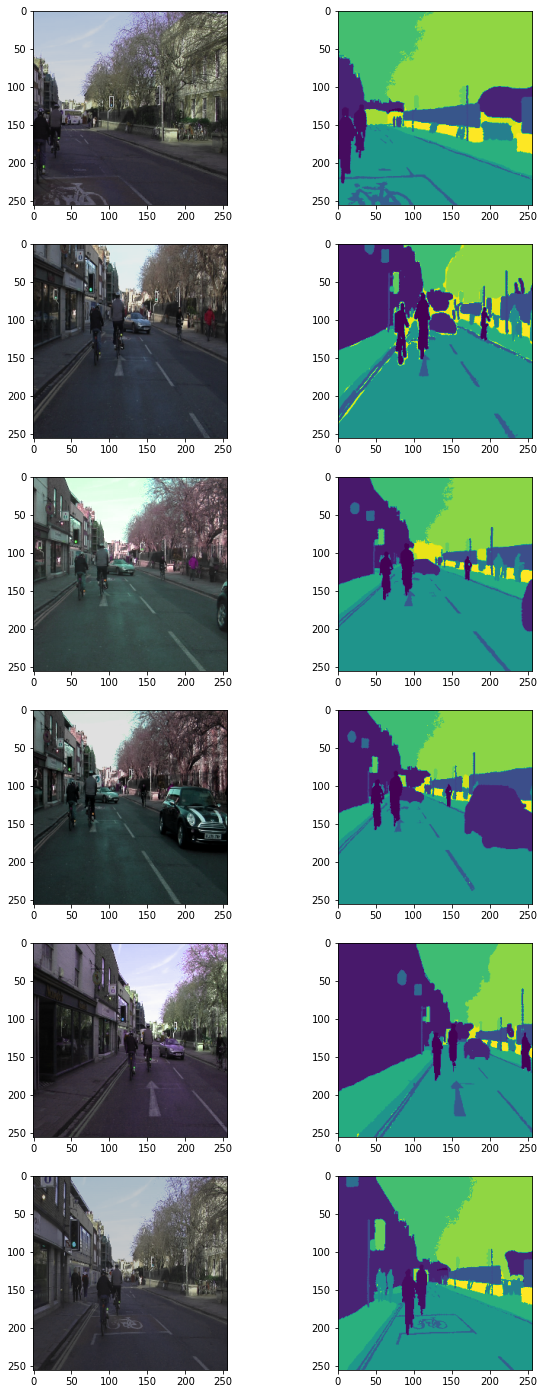

In [ ]:
x,y = next(iter(train_dataloader))
plt.figure(figsize=(10,25))

cont = 0
for k in range(0, batch_size):
    cont += 1
    plt.subplot(batch_size, 2, cont)
    plt.imshow(dnorm(x[k], mean, std).permute(1,2,0))

    cont += 1
    plt.subplot(batch_size, 2, cont)
    plt.imshow(y[k].squeeze())

## Modelo U-Net

Utilizando o modelo pré-treinado: https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=num_classes, init_features=64, pretrained=False)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


## Dice Loss - Multiclasse

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth = 1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_true, y_pred):
        num_classes = y_pred.shape[1]
        y_pred = torch.softmax(y_pred, dim=1) # probabilidades para cada classe
        b_size = y_pred.shape[0] # determina o batch size

        # a loss é calculada pra cada classe e somada, para cada imagem do batch, separadamente
        loss = 0
        for c in range(num_classes):
            pred_c = y_pred[:,c,:,:].contiguous().view(b_size,-1) # probabilidades da classe c
            true_c = 1*(y_true == c).contiguous().view(b_size,-1) # =1 para valores da classe c
            
            inter = (pred_c * true_c).sum()
            loss += (2 * inter + self.smooth) / (pred_c.sum() + true_c.sum() + self.smooth)

        return 1. - loss

## Modelo Lightning

In [ ]:
class LightningClassifier(LightningModule):
    def __init__(self, hparams, modelo):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.criterion = DiceLoss()
        self.model = modelo

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.model(x.float())

        batch_losses = self.criterion(y, logits)
        loss = batch_losses.mean()
        run['train/batch_loss'].log(loss)

        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x.float())
        batch_losses = self.criterion(y, logits)
        
        return {'batch_losses': batch_losses}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['valid/loss'].log(avg_loss)

        metrics = {'valid_loss': avg_loss.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}

        self.log('valid_loss', avg_loss.item(), prog_bar=True)

        return output
  
    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x.float())
        batch_losses = self.criterion(y, logits)

        return {'batch_losses': batch_losses}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['valid/loss'].log(avg_loss)
        metrics = {'Test loss': avg_loss.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss.item())

        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'])
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.9)
        return [optimizer], [scheduler]

In [ ]:
hparams = {
    'max_epochs': 100,
    'learning_rate': 0.001
}

pl_model = LightningClassifier(hparams=hparams, modelo=model)
trainer = Trainer(max_epochs=hparams['max_epochs'], gpus=1)
trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | criterion | DiceLoss | 0     
1 | model     | UNet     | 31.0 M
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.159   Total estimated model params size (MB)


Global seed set to 123


## Métricas

In [ ]:
train_dataloader_shuffle_off = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
trainer.test(pl_model, train_dataloader_shuffle_off)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.09603139758110046}
--------------------------------------------------------------------------------


[{'test_loss': 0.09603139758110046}]

In [ ]:
trainer.test(pl_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1409420669078827}
--------------------------------------------------------------------------------


[{'test_loss': 0.1409420669078827}]

In [ ]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.1234370768070221}
--------------------------------------------------------------------------------


[{'test_loss': 0.1234370768070221}]

## Visualizando os resultados

### Conjunto de treinamento

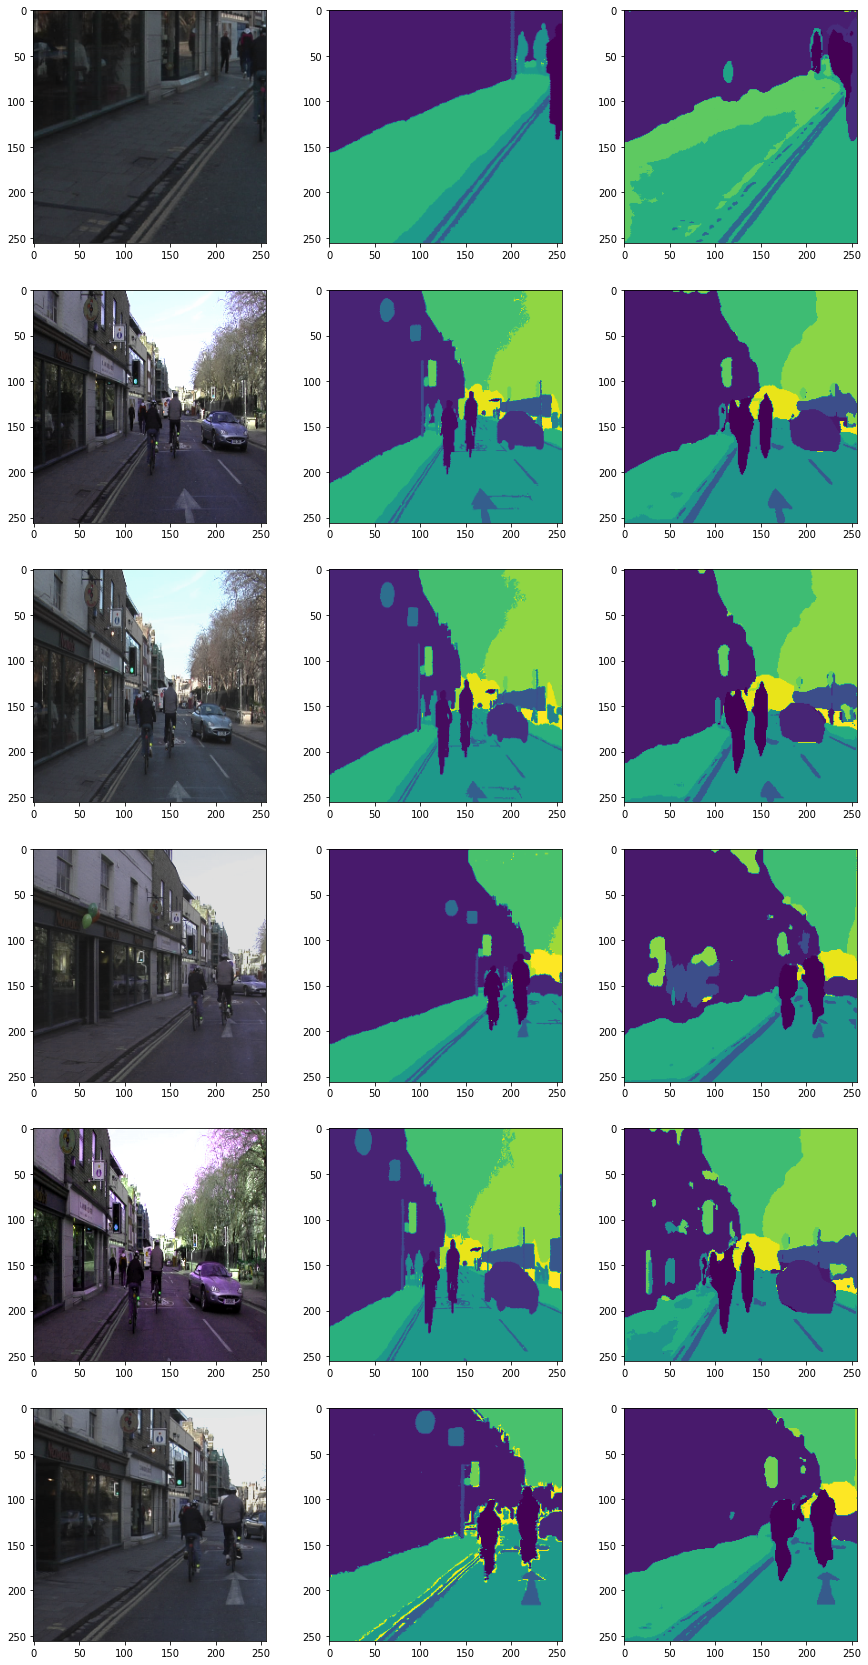

In [ ]:
x,y = next(iter(train_dataloader_shuffle_off))
out = model.forward(x)
outs = torch.argmax(out, dim=1)

cont = 0
plt.figure(figsize=(15,30))
for k in range(batch_size):

  cont += 1
  plt.subplot(batch_size, 3, cont)
  x_d = dnorm(x[k], mean, std)
  plt.imshow(np.transpose(x_d, (1,2,0)).numpy())

  cont += 1
  plt.subplot(batch_size,3,cont)
  plt.imshow(y[k,].squeeze())

  cont += 1
  plt.subplot(batch_size,3,cont)
  plt.imshow(outs[k,])

### Conjunto de testes

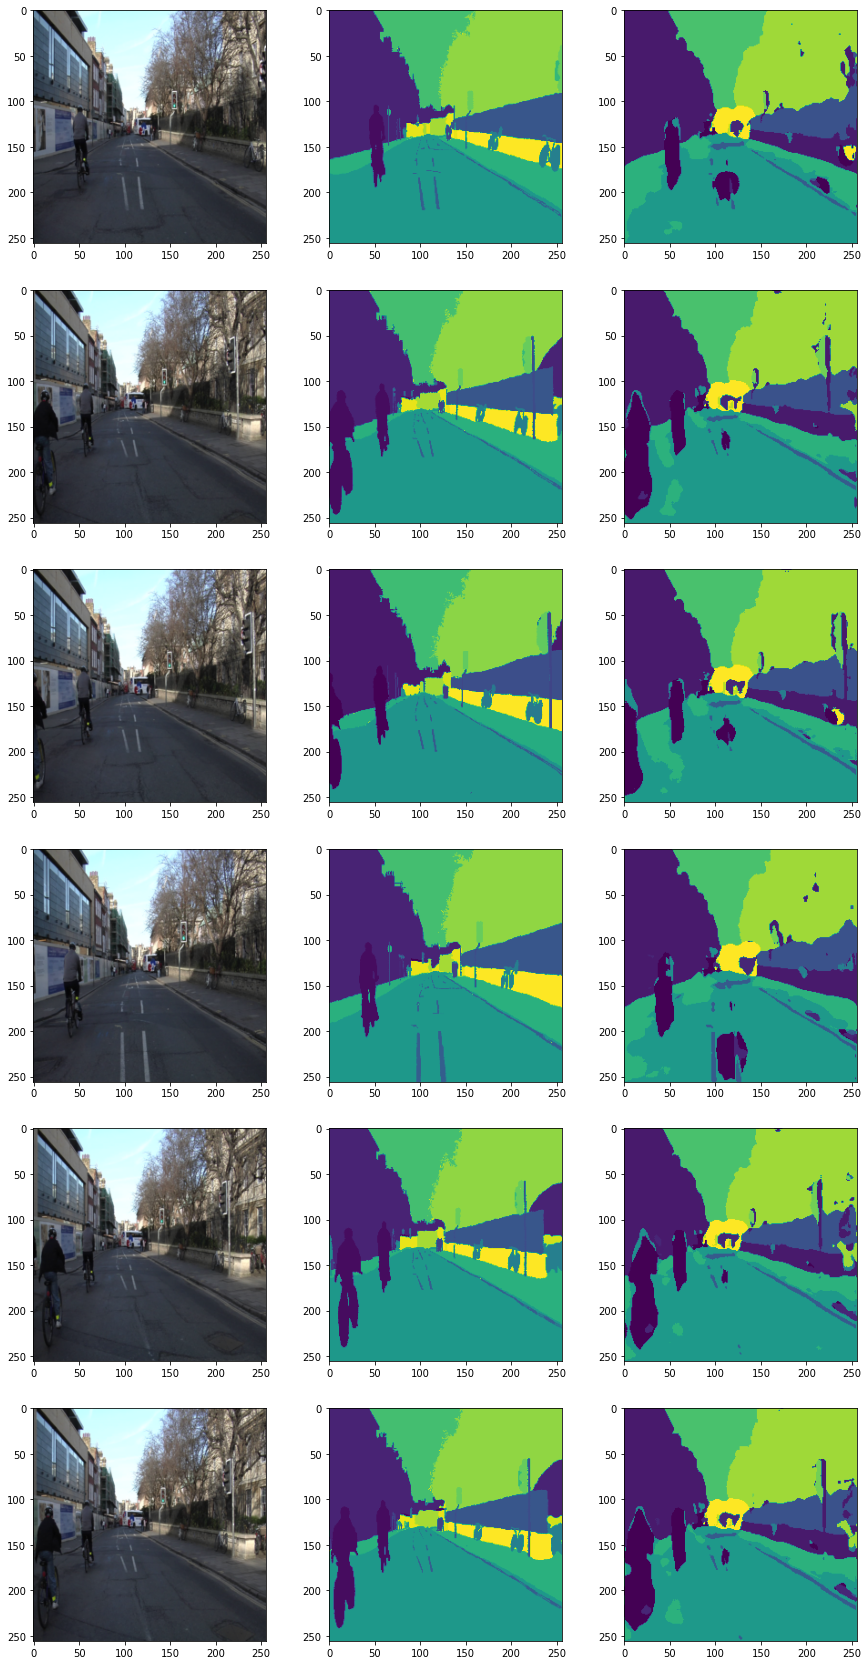

In [ ]:
x,y = next(iter(test_dataloader))
out = model.forward(x)
outs = torch.argmax(out, dim=1)

cont = 0
plt.figure(figsize=(15,30))
for k in range(batch_size):

  cont += 1
  plt.subplot(batch_size, 3, cont)
  x_d = dnorm(x[k], mean, std)
  plt.imshow(np.transpose(x_d, (1,2,0)).numpy())

  cont += 1
  plt.subplot(batch_size,3,cont)
  plt.imshow(y[k,].squeeze())

  cont += 1
  plt.subplot(batch_size,3,cont)
  plt.imshow(outs[k,])